In [1]:
import numpy as np
from scipy import sparse as sp
from scipy.sparse.linalg import spsolve
from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import time, sys
import pickle
import torch
import torch.nn as nn

In [2]:
# Choose Re=1000 or Re=100
Re=10000

In [3]:
# choose # of DEIM basis file name
if Re==10000:
    file_name="./data/snapshot_full_high_Re.p"
    file_name_inter="./data/snapshot_full_inter_high_Re.p"
    file_name_r_tilde='./data/snapshot_r_tilde_high_Re_batch_240.p'
elif Re==100:
    file_name="./data/snapshot_full_low_Re.p"
    file_name_inter="./data/snapshot_full_inter_low_Re.p"
    file_name_r_tilde='./data/snapshot_r_tilde_low_Re_batch_240.p'
else:
    raise NameError('{} is given for Re, but it must be either 100 or 10000'.format(Re))

In [4]:
# load full order solution
if Re==10000:
    FOM_solution=pickle.load(open('./data/FOM_high_Re.p','rb'))
elif Re==100:
    FOM_solution=pickle.load(open('./data/FOM_low_Re.p','rb'))
else:
    raise NameError('{} is given for Re, but it must be either 100 or 10000'.format(Re))
    
u_full=FOM_solution['u']
v_full=FOM_solution['v']

In [5]:
# Set parameters
if Re==10000:
    nx=60
    ny=60
    nt=1500
elif Re==100:
    nx=60
    ny=60
    nt=1500
else:
    raise NameError('{} is given for Re, but it must be either 100 or 10000'.format(Re))
    
nxy=(nx-2)*(ny-2)
dx=1/(nx-1)
dy=1/(ny-1)
dt=2/nt

I=sp.eye(nxy,format='csr')

# full indicies, free indicies, fixed indicies
[xv,yv]=np.meshgrid(np.linspace(0,1,nx),np.linspace(0,1,ny),indexing='xy')
x=xv.flatten()
y=yv.flatten()

multi_index_i,multi_index_j=np.meshgrid(np.arange(nx),np.arange(ny),indexing='xy')
full_multi_index=(multi_index_j.flatten(),multi_index_i.flatten())
free_multi_index=(multi_index_j[1:-1,1:-1].flatten(),multi_index_i[1:-1,1:-1].flatten())
x0_multi_index=(multi_index_j[1:-1,0].flatten(),multi_index_i[1:-1,0].flatten())
x1_multi_index=(multi_index_j[1:-1,-1].flatten(),multi_index_i[1:-1,-1].flatten())
y0_multi_index=(multi_index_j[0,1:-1].flatten(),multi_index_i[0,1:-1].flatten())
y1_multi_index=(multi_index_j[-1,1:-1].flatten(),multi_index_i[-1,1:-1].flatten())

dims=(ny,nx)
full_raveled_indicies=np.ravel_multi_index(full_multi_index,dims)
free_raveled_indicies=np.ravel_multi_index(free_multi_index,dims)
x0_raveled_indicies=np.ravel_multi_index(x0_multi_index,dims)
x1_raveled_indicies=np.ravel_multi_index(x1_multi_index,dims)
x01_raveled_indicies=np.concatenate((x0_raveled_indicies,x1_raveled_indicies))
y0_raveled_indicies=np.ravel_multi_index(y0_multi_index,dims)
y1_raveled_indicies=np.ravel_multi_index(y1_multi_index,dims)
y01_raveled_indicies=np.concatenate((y0_raveled_indicies,y1_raveled_indicies))
fixed_raveled_indicies=np.setdiff1d(full_raveled_indicies,free_raveled_indicies)

# boundary one-hot vector
x0_one_hot=np.eye(nx-2)[0]
y0_one_hot=np.eye(ny-2)[0]
x1_one_hot=np.eye(nx-2)[-1]
y1_one_hot=np.eye(ny-2)[-1]

# inner grid
inner_multi_index_i,inner_multi_index_j=np.meshgrid(np.arange(nx-2),np.arange(ny-2),indexing='xy')
inner_x_multi_index=(np.concatenate((inner_multi_index_j[:,0].flatten(),inner_multi_index_j[:,-1].flatten())),
                     np.concatenate((inner_multi_index_i[:,0].flatten(),inner_multi_index_i[:,-1].flatten())))
inner_y_multi_index=(np.concatenate((inner_multi_index_j[0,:].flatten(),inner_multi_index_j[-1,:].flatten())),
                     np.concatenate((inner_multi_index_i[0,:].flatten(),inner_multi_index_i[-1,:].flatten())))

inner_dims=(ny-2,nx-2)
inner_x_raveled_indicies=np.ravel_multi_index(inner_x_multi_index,inner_dims)
inner_y_raveled_indicies=np.ravel_multi_index(inner_y_multi_index,inner_dims)

In [6]:
# first order derivative
# central
Mb=sp.diags([np.ones(nx-2),-np.ones(nx-2)],[0,-1],(nx-2,nx-2))
M=sp.kron(sp.eye(ny-2),Mb,format="csr")

Ib=sp.eye(nx-2)
N=sp.kron(sp.diags([np.ones(ny-2),-np.ones(ny-2)],[0,-1],(ny-2,ny-2)),Ib,format="csr")

# laplacian operator
Dxb=sp.diags([-2*np.ones(nx-2),np.ones(nx-2),np.ones(nx-2)],[0,-1,1],(nx-2,nx-2))
Dx=sp.kron(sp.eye(ny-2),Dxb,format="csr")

Ib=sp.eye(nx-2)
Dy=sp.kron(sp.diags([-2*np.ones(ny-2),np.ones(ny-2),np.ones(ny-2)],[0,-1,1],(ny-2,ny-2)),Ib,format="csr")

In [7]:
# IC
u0=u_full[0]
v0=v_full[0]

In [8]:
# boundary for first order derivative term
Bdudx0_cur=np.kron(u0[x0_raveled_indicies],x0_one_hot)
Bdudy0_cur=np.kron(y0_one_hot,u0[y0_raveled_indicies])
Bdvdx0_cur=np.kron(v0[x0_raveled_indicies],x0_one_hot)
Bdvdy0_cur=np.kron(y0_one_hot,v0[y0_raveled_indicies])
Bdudx1_cur=np.kron(u0[x1_raveled_indicies],x1_one_hot)
Bdudy1_cur=np.kron(y1_one_hot,u0[y1_raveled_indicies])
Bdvdx1_cur=np.kron(v0[x1_raveled_indicies],x1_one_hot)
Bdvdy1_cur=np.kron(y1_one_hot,v0[y1_raveled_indicies])
    
# boundary for second order derivative term
bxu_cur=np.zeros(nxy)
byu_cur=np.zeros(nxy)
bxv_cur=np.zeros(nxy)
byv_cur=np.zeros(nxy)

bxu_cur[inner_x_raveled_indicies]=u0[x01_raveled_indicies]
byu_cur[inner_y_raveled_indicies]=u0[y01_raveled_indicies]
bxv_cur[inner_x_raveled_indicies]=v0[x01_raveled_indicies]
byv_cur[inner_y_raveled_indicies]=v0[y01_raveled_indicies]

In [9]:
if Re==10000:
    file_name_AE="./model/AE_high_Re_v3_batch_240.p"
    latent_dim=5
elif Re==100:
    file_name_AE="./model/AE_low_Re_v3_batch_240.p"
    latent_dim=5
else:
    raise NameError('{} is given for Re, but it must be either 100 or 10000'.format(Re))

AE = pickle.load(open(file_name_AE,'rb'))

en_wu1=AE['en_wu1']
en_bu1=AE['en_bu1']
en_wu2=AE['en_wu2']
de_wu1=AE['de_wu1']
de_bu1=AE['de_bu1']
de_wu2=AE['de_wu2']
de_wu1T=AE['de_wu1T']
de_wu2T=AE['de_wu2T']
de_wu2_sp=AE['de_wu2_sp']
de_wu2T_sp=AE['de_wu2T_sp']
u_ref=AE['u_ref']

en_wv1=AE['en_wv1']
en_bv1=AE['en_bv1']
en_wv2=AE['en_wv2']
de_wv1=AE['de_wv1']
de_bv1=AE['de_bv1']
de_wv2=AE['de_wv2']
de_wv1T=AE['de_wv1T']
de_wv2T=AE['de_wv2T']
de_wv2_sp=AE['de_wv2_sp']
de_wv2T_sp=AE['de_wv2T_sp']
v_ref=AE['v_ref']

In [10]:
def sigmoid_np(input):
    return (1.0/(1.0+np.exp(-input))).astype('float32')

def encoder_u_np_forward(x):
    z1 = en_wu1.dot(x) + en_bu1
    a1 = sigmoid_np(z1)
    y = en_wu2.dot(a1)   
    return y

def decoder_u_np_forward(x):
    z1 = de_wu1.dot(x) + de_bu1
    a1 = sigmoid_np(z1)
    y = de_wu2.dot(a1)  
    return y

def decoder_u_sp_forward(x):
    z1 = de_wu1.dot(x) + de_bu1
    a1 = sigmoid_np(z1)
    y = sp.csr_matrix.dot(de_wu2_sp,a1)
    return y

def encoder_v_np_forward(x):
    z1 = en_wv1.dot(x) + en_bv1
    a1 = sigmoid_np(z1)
    y = en_wv2.dot(a1)   
    return y

def decoder_v_np_forward(x):
    z1 = de_wv1.dot(x) + de_bv1
    a1 = sigmoid_np(z1)
    y = de_wv2.dot(a1)   
    return y

def decoder_v_sp_forward(x):
    z1 = de_wv1.dot(x) + de_bv1
    a1 = sigmoid_np(z1)
    y = sp.csr_matrix.dot(de_wv2_sp,a1)
    return y

def decoder_u_np_forward_backwardT(x):
    z1 = de_wu1.dot(x) + de_bu1
    a1 = sigmoid_np(z1)
    y = de_wu2.dot(a1)

    dout = de_wu1T
    dout = (a1*(1-a1))*dout
    dydxT = dout.dot(de_wu2T)   
    return y,dydxT

def decoder_u_sp_forward_backwardT(x):
    z1 = de_wu1.dot(x) + de_bu1
    a1 = sigmoid_np(z1)
    y = sp.csr_matrix.dot(de_wu2_sp,a1)

    dout = de_wu1T
    dout = (a1*(1-a1))*dout
    dydxT = sp.csr_matrix.dot(dout,de_wu2T_sp)
    return y,dydxT

def decoder_v_np_forward_backwardT(x):
    z1 = de_wv1.dot(x) + de_bv1
    a1 = sigmoid_np(z1)
    y = de_wv2.dot(a1)

    dout = de_wv1T
    dout = (a1*(1-a1))*dout
    dydxT = dout.dot(de_wv2T)   
    return y,dydxT

def decoder_v_sp_forward_backwardT(x):
    z1 = de_wv1.dot(x) + de_bv1
    a1 = sigmoid_np(z1)
    y = sp.csr_matrix.dot(de_wv2_sp,a1)

    dout = de_wv1T
    dout = (a1*(1-a1))*dout
    dydxT = sp.csr_matrix.dot(dout,de_wv2T_sp)
    return y,dydxT

In [11]:
I_hat=np.eye(latent_dim,dtype='float32')

maxitr=4
tol=1e-6

u_hat0=encoder_u_np_forward(u0[free_raveled_indicies].astype('float32')-u_ref)
v_hat0=encoder_v_np_forward(v0[free_raveled_indicies].astype('float32')-v_ref)

In [12]:
M=M.astype('float32')
N=N.astype('float32')

Dx=Dx.astype('float32')
Dy=Dy.astype('float32')

MT=M.T
NT=N.T

Mu_ref=M.dot(u_ref)
Nu_ref=N.dot(u_ref)
Mv_ref=M.dot(v_ref)
Nv_ref=N.dot(v_ref)

Dxu_ref=Dx.dot(u_ref)
Dyu_ref=Dy.dot(u_ref)
Dxv_ref=Dx.dot(v_ref)
Dyv_ref=Dy.dot(v_ref)

In [13]:
au1_cur=(-1/dx*u_ref*(Mu_ref-Bdudx0_cur)-1/dy*v_ref*(Nu_ref-Bdudy0_cur) \
+1/(Re*dx**2)*(Dxu_ref+bxu_cur)+1/(Re*dy**2)*(Dyu_ref+byu_cur)).astype('float32')
Au2_cur=(-1/dx*(sp.diags(u_ref,format='csr').dot(M)+sp.diags(Mu_ref-Bdudx0_cur,format='csr')) \
-1/dy*sp.diags(v_ref,format='csr').dot(N) \
+1/(Re*dx**2)*Dx+1/(Re*dy**2)*Dy).astype('float32')
au3_cur=(-1/dy*(Nu_ref-Bdudy0_cur)).astype('float32')

av1_cur=(-1/dx*u_ref*(Mv_ref-Bdvdx0_cur)-1/dy*v_ref*(Nv_ref-Bdvdy0_cur) \
+1/(Re*dx**2)*(Dxv_ref+bxv_cur)+1/(Re*dy**2)*(Dyv_ref+byv_cur)).astype('float32')
av2_cur=(-1/dx*(Mv_ref-Bdvdx0_cur)).astype('float32')
Av3_cur=(-1/dx*sp.diags(u_ref,format='csr').dot(M) \
-1/dy*(sp.diags(v_ref,format='csr').dot(N)+sp.diags(Nv_ref-Bdvdy0_cur,format='csr')) \
+1/(Re*dx**2)*Dx+1/(Re*dy**2)*Dy).astype('float32')

Au2T_cur=Au2_cur.T
Av3T_cur=Av3_cur.T

In [14]:
def DEIM(phi_f, nfeval=None):
    
    ninf=np.NINF
    n,m=np.shape(phi_f)
    if nfeval==None:
        nfeval=m
        
    if nfeval<m:
        print("ill-posed\n")
        print("set # sampling equal to # modes")
        nfeval=m
        
    div,mod=np.divmod(nfeval,m)
    
    I=np.eye(n)
    
    l=0
    ns=div+mod
    u=np.reshape(phi_f[:,l],(n,1))
    p=np.argsort(-np.abs(u),axis=0,kind='stable')[:ns]
#     p=np.argmax(np.abs(u)) # when ns=1
    ep=np.reshape(I[:,p],(n,ns))
    U=u
    P=ep

    ns=div
    for l in range(1,m):
        u=np.reshape(phi_f[:,l],(n,1))
        PT=np.transpose(P)
        c=np.linalg.lstsq(PT@U,PT@u,rcond=None)[0]
        r=np.abs(u-U@c)
        r[p]=ninf
        p=np.append(p,np.argsort(-r,axis=0,kind='stable')[:ns]) # ns!=1
        ep=np.reshape(I[:,p[-ns:]],(n,ns))
        U=np.concatenate((U,u),axis=1)
        P=np.concatenate((P,ep),axis=1)
        
    return p

# Change # of basis and samples

In [15]:
# load sanpshots
# snapshot: just full order solution
# temp=pickle.load(open(file_name,'rb'))
# DEIM_snapshot={'u':temp['u'][:,free_raveled_indicies],'v':temp['v'][:,free_raveled_indicies]}

# snapshot: full order solution including intermediate values
DEIM_snapshot=pickle.load(open(file_name_inter,'rb'))

# snapshot: residual tilde during NM-ROM (LSPG)
# DEIM_snapshot=pickle.load(open(file_name_r_tilde,'rb'))

snapshot_u=DEIM_snapshot['u']
snapshot_v=DEIM_snapshot['v']

In [16]:
# do svd decomposition
U_u,S_u,V_uT=np.linalg.svd(snapshot_u.T,full_matrices=False)
U_v,S_v,V_vT=np.linalg.svd(snapshot_v.T,full_matrices=False)
pickle.dump({'U_u':U_u,'U_v':U_v},open('./model/NMROM_residual_basis.p','wb'))
# U=pickle.load(open('./model/NMROM_residual_basis.p','rb'))
# U_u=U['U_u']
# U_v=U['U_v']

In [17]:
DEIM_test_tstart=time.time()

# choose # of DEIM basis and DEIM samples
DEIM_min=40
DEIM_max=60

n_test=int((DEIM_max-DEIM_min)*(DEIM_max-DEIM_min+1)/2)
print('Total # of test: {}'.format(n_test))

# save test results: [DEIM_basis, DEIM_samples, Time_elapsed, Max_rel_err]
test_results=np.zeros((n_test,4))

test_count=0
for DEIM_basis in np.arange(DEIM_min,DEIM_max):
    for DEIM_samples in np.arange(DEIM_basis,DEIM_max):
        test_count+=1
        print()
        print('Test #{}'.format(test_count))
        print('-'*72)
        print('DEIM_basis: {}, DEIM_samples: {}'.format(DEIM_basis,DEIM_samples))
        
        try:
            phi_u=U_u[:,:DEIM_basis]
            phi_v=U_v[:,:DEIM_basis]

            # Find DEIM smaple points and precompute
            z_u=DEIM(phi_u,DEIM_samples)
            z_v=DEIM(phi_v,DEIM_samples)

            Pu=phi_u.dot(np.linalg.pinv(phi_u[z_u]))
            Pv=phi_v.dot(np.linalg.pinv(phi_v[z_v]))

            PuTPu=Pu.T.dot(Pu)
            PvTPv=Pv.T.dot(Pv)

            # neigbor sample points
            z_uA=np.unique(np.nonzero(Au2_cur[z_u])[1])
            z_uM=np.unique(np.nonzero(M[z_u])[1])
            z_uN=np.unique(np.nonzero(N[z_u])[1])

            z_vA=np.unique(np.nonzero(Av3_cur[z_v])[1])
            z_vM=np.unique(np.nonzero(M[z_v])[1])
            z_vN=np.unique(np.nonzero(N[z_v])[1])

            z_union=np.union1d(z_uA,z_vA)

            z_uA_ind=z_union.searchsorted(z_uA)
            z_uM_ind=z_union.searchsorted(z_uM)
            z_uN_ind=z_union.searchsorted(z_uN)
            z_u_ind=z_union.searchsorted(z_u)

            z_vA_ind=z_union.searchsorted(z_vA)
            z_vM_ind=z_union.searchsorted(z_vM)
            z_vN_ind=z_union.searchsorted(z_vN)
            z_v_ind=z_union.searchsorted(z_v)

            # subnet for u
            m,M2=de_wu2.shape

            class Decoder_U_FC(nn.Module):

                def __init__(self,):
                    super(Decoder_U_FC, self).__init__()
                    self.fc1 = nn.Linear(latent_dim,M2)
                    self.fc1.weight = nn.Parameter(torch.ones(de_wu1.shape))
                    self.fc1.bias = nn.Parameter(torch.ones(de_bu1.shape))
#                     self.fc1.weight = nn.Parameter(torch.tensor(de_wu1))
#                     self.fc1.bias = nn.Parameter(torch.tensor(de_bu1))

                    self.fc2 = nn.Linear(M2,m,bias=False)
                    self.fc2.weight = nn.Parameter(torch.ones(de_wu2.shape))
#                     self.fc2.weight = nn.Parameter(torch.tensor(de_wu2))

                def forward(self, x):
                    x = self.fc1(x)
                    x = self.fc2(x)
                    return x

            model = Decoder_U_FC()

            x_in=torch.ones(latent_dim)
            y_out=model(x_in)

            p_hr=z_union

            upstream=torch.zeros_like(y_out)
            upstream[p_hr]=1.0

            y_out.backward(upstream)

            # masks for subnet
            wu1_mask=model.fc1.weight.grad
            wu2_mask=model.fc2.weight.grad

            bu1_mask=model.fc1.bias.grad

            # subnet sparse weight
            idx1=wu1_mask.to_sparse()._indices()
            i1=idx1.numpy()[0]
            j1=idx1.numpy()[1]
            v1=de_wu1[i1,j1]
            wu1_sb_sp=sp.csr_matrix(sp.csr_matrix((v1,(i1,j1)),shape=wu1_mask.shape).toarray())

            idx2=wu2_mask.to_sparse()._indices()
            i2=idx2.numpy()[0]
            j2=idx2.numpy()[1]
            v2=de_wu2[i2,j2]
            wu2_sb_sp=sp.csr_matrix(sp.csr_matrix((v2,(i2,j2)),shape=wu2_mask.shape).toarray())

            # subnet compressed weight
            i1,j1,v1=sp.find(wu1_sb_sp)
            i1_unique,i1_inverse=np.unique(i1,return_inverse=True)
            i1_comp=np.arange(i1_unique.size)
            i1_comp=i1_comp[i1_inverse]
            j1_unique,j1_inverse=np.unique(j1,return_inverse=True)
            j1_comp=np.arange(j1_unique.size)
            j1_comp=j1_comp[j1_inverse]
            wu1_sb_comp_sp=sp.csr_matrix((v1,(i1_comp,j1_comp)),shape=(i1_unique.size,j1_unique.size))

            i2,j2,v2=sp.find(wu2_sb_sp)
            i2_unique,i2_inverse=np.unique(i2,return_inverse=True)
            i2_comp=np.arange(i2_unique.size)
            i2_comp=i2_comp[i2_inverse]
            j2_unique,j2_inverse=np.unique(j2,return_inverse=True)
            j2_comp=np.arange(j2_unique.size)
            j2_comp=j2_comp[j2_inverse]
            wu2_sb_comp_sp=sp.csr_matrix((v2,(i2_comp,j2_comp)),shape=(i2_unique.size,j2_unique.size))

            wu1_sb_comp_dense=wu1_sb_comp_sp.toarray()
            wu1_sb_comp_dense=wu1_sb_comp_dense[j2_unique]
            wu2_sb_comp_dense=wu2_sb_comp_sp.toarray()

            wu1_sb_comp_denseT=wu1_sb_comp_dense.T
            wu2_sb_comp_denseT=wu2_sb_comp_dense.T

            # subnet compressed bias
            bu1_sb_comp_dense=de_bu1[i1_unique]
            bu1_sb_comp_dense=bu1_sb_comp_dense[j2_unique]

            # Using sparse matrix
            wu2_sb_comp_sp=sp.csr_matrix(wu2_sb_comp_dense,dtype='float32')
            wu2_sb_comp_spT=sp.csr_matrix(wu2_sb_comp_denseT,dtype='float32')

            def decoder_u_sb_np_forward(x):
                z1 = wu1_sb_comp_dense.dot(x) + bu1_sb_comp_dense
                a1 = sigmoid_np(z1)
                y = wu2_sb_comp_dense.dot(a1)  
                return y

            def decoder_u_sb_np_forward_backwardT(x):
                z1 = wu1_sb_comp_dense.dot(x) + bu1_sb_comp_dense
                a1 = sigmoid_np(z1)
                y = wu2_sb_comp_dense.dot(a1) 

                dout = wu1_sb_comp_denseT
                dout = (a1*(1-a1))*dout
                dydxT = dout.dot(wu2_sb_comp_denseT)
                return y,dydxT

            def decoder_u_sb_sp_forward(x):
                z1 = wu1_sb_comp_dense.dot(x) + bu1_sb_comp_dense
                a1 = sigmoid_np(z1)
                y = sp.csr_matrix.dot(wu2_sb_comp_sp,a1)
                return y

            def decoder_u_sb_sp_forward_backwardT(x):
                z1 = wu1_sb_comp_dense.dot(x) + bu1_sb_comp_dense
                a1 = sigmoid_np(z1)
                y = sp.csr_matrix.dot(wu2_sb_comp_sp,a1)

                dout = wu1_sb_comp_denseT
                dout = (a1*(1-a1))*dout
                dydxT = sp.csr_matrix.dot(dout,wu2_sb_comp_spT)
                return y,dydxT

            # subnet for v
            m,M2=de_wv2.shape

            class Decoder_V_FC(nn.Module):

                def __init__(self,):
                    super(Decoder_V_FC, self).__init__()
                    self.fc1 = nn.Linear(latent_dim,M2)
                    self.fc1.weight = nn.Parameter(torch.tensor(de_wv1))
                    self.fc1.bias = nn.Parameter(torch.tensor(de_bv1))

                    self.fc2 = nn.Linear(M2,m,bias=False)
                    self.fc2.weight = nn.Parameter(torch.tensor(de_wv2))

                def forward(self, x):
                    x = self.fc1(x)
                    x = self.fc2(x)
                    return x

            model = Decoder_V_FC()

            x_in=torch.ones(latent_dim)
            y_out=model(x_in)

            p_hr=z_union

            upstream=torch.zeros_like(y_out)
            upstream[p_hr]=1.0

            y_out.backward(upstream)

            # masks for subnet
            wv1_mask=model.fc1.weight.grad
            wv2_mask=model.fc2.weight.grad

            bv1_mask=model.fc1.bias.grad

            # subnet sparse weight
            idx1=wv1_mask.to_sparse()._indices()
            i1=idx1.numpy()[0]
            j1=idx1.numpy()[1]
            v1=de_wv1[i1,j1]
            wv1_sb_sp=sp.csr_matrix(sp.csr_matrix((v1,(i1,j1)),shape=wv1_mask.shape).toarray())

            idx2=wv2_mask.to_sparse()._indices()
            i2=idx2.numpy()[0]
            j2=idx2.numpy()[1]
            v2=de_wv2[i2,j2]
            wv2_sb_sp=sp.csr_matrix(sp.csr_matrix((v2,(i2,j2)),shape=wv2_mask.shape).toarray())

            # subnet compressed weight
            i1,j1,v1=sp.find(wv1_sb_sp)
            i1_unique,i1_inverse=np.unique(i1,return_inverse=True)
            i1_comp=np.arange(i1_unique.size)
            i1_comp=i1_comp[i1_inverse]
            j1_unique,j1_inverse=np.unique(j1,return_inverse=True)
            j1_comp=np.arange(j1_unique.size)
            j1_comp=j1_comp[j1_inverse]
            wv1_sb_comp_sp=sp.csr_matrix((v1,(i1_comp,j1_comp)),shape=(i1_unique.size,j1_unique.size))

            i2,j2,v2=sp.find(wv2_sb_sp)
            i2_unique,i2_inverse=np.unique(i2,return_inverse=True)
            i2_comp=np.arange(i2_unique.size)
            i2_comp=i2_comp[i2_inverse]
            j2_unique,j2_inverse=np.unique(j2,return_inverse=True)
            j2_comp=np.arange(j2_unique.size)
            j2_comp=j2_comp[j2_inverse]
            wv2_sb_comp_sp=sp.csr_matrix((v2,(i2_comp,j2_comp)),shape=(i2_unique.size,j2_unique.size))

            wv1_sb_comp_dense=wv1_sb_comp_sp.toarray()
            wv2_sb_comp_dense=wv2_sb_comp_sp.toarray()

            wv1_sb_comp_denseT=wv1_sb_comp_dense.T
            wv2_sb_comp_denseT=wv2_sb_comp_dense.T

            # subnet compressed bias
            bv1_sb_comp_dense=de_bv1[i1_unique]

            # Using sparse matrix
            wv2_sb_comp_sp=sp.csr_matrix(wv2_sb_comp_dense,dtype='float32')
            wv2_sb_comp_spT=sp.csr_matrix(wv2_sb_comp_denseT,dtype='float32')

            def decoder_v_sb_np_forward(x):
                z1 = wv1_sb_comp_dense.dot(x) + bv1_sb_comp_dense
                a1 = sigmoid_np(z1)
                y = wv2_sb_comp_dense.dot(a1)  
                return y

            def decoder_v_sb_np_forward_backwardT(x):
                z1 = wv1_sb_comp_dense.dot(x) + bv1_sb_comp_dense
                a1 = sigmoid_np(z1)
                y = wv2_sb_comp_dense.dot(a1) 

                dout = wv1_sb_comp_denseT
                dout = (a1*(1-a1))*dout
                dydxT = dout.dot(wv2_sb_comp_denseT)
                return y,dydxT

            def decoder_v_sb_sp_forward(x):
                z1 = wv1_sb_comp_dense.dot(x) + bv1_sb_comp_dense
                a1 = sigmoid_np(z1)
                y = sp.csr_matrix.dot(wv2_sb_comp_sp,a1)
                return y

            def decoder_v_sb_sp_forward_backwardT(x):
                z1 = wv1_sb_comp_dense.dot(x) + bv1_sb_comp_dense
                a1 = sigmoid_np(z1)
                y = sp.csr_matrix.dot(wv2_sb_comp_sp,a1)

                dout = wv1_sb_comp_denseT
                dout = (a1*(1-a1))*dout
                dydxT = sp.csr_matrix.dot(dout,wv2_sb_comp_spT)
                return y,dydxT

            # precompute
            ZuTau1_cur=au1_cur[z_u]
            ZuTAu2_cur=Au2_cur[z_u][:,z_uA]
            ZuTau3_cur=au3_cur[z_u]

            ZvTav1_cur=av1_cur[z_v]
            ZvTav2_cur=av2_cur[z_v]
            ZvTAv3_cur=Av3_cur[z_v][:,z_vA]

            Au2T_curZu=Au2T_cur[z_uA][:,z_u]
            Av3T_curZv=Av3T_cur[z_vA][:,z_v]

            ZuTM=M[z_u][:,z_uM]
            ZuTN=N[z_u][:,z_uN]
            ZvTM=M[z_v][:,z_vM]
            ZvTN=N[z_v][:,z_vN]

            MTZu=MT[z_uM][:,z_u]
            NTZu=NT[z_uN][:,z_u]
            MTZv=MT[z_vM][:,z_v]
            NTZv=NT[z_vN][:,z_v]

            # define functions
            def ZuTtheta_u(g_u_sb,g_v_sb,ZuTMg_u,ZuTNg_u):
                return -1/dx*g_u_sb[z_u_ind]*ZuTMg_u-1/dy*g_v_sb[z_u_ind]*ZuTNg_u

            def ZvTtheta_v(g_u_sb,g_v_sb,ZvTMg_v,ZvTNg_v):
                return -1/dx*g_u_sb[z_v_ind]*ZvTMg_v-1/dy*g_v_sb[z_v_ind]*ZvTNg_v

            def dtheta_udu_hatTZu(g_u_sb,g_v_sb,ZuTMg_u,Jg_u_sbT,Jg_uTMTZu,Jg_uTNTZu):
                return -1/dx*(ZuTMg_u*Jg_u_sbT[:,z_u_ind]+g_u_sb[z_u_ind]*Jg_uTMTZu)-1/dy*g_v_sb[z_u_ind]*Jg_uTNTZu

            def dtheta_udv_hatTZu(ZuTNg_u,Jg_v_sbT):
                return -1/dy*ZuTNg_u*Jg_v_sbT[:,z_u_ind]

            def dtheta_vdu_hatTZv(ZvTMg_v,Jg_u_sbT):
                return -1/dx*ZvTMg_v*Jg_u_sbT[:,z_v_ind]

            def dtheta_vdv_hatTZv(g_u_sb,g_v_sb,ZvTNg_v,Jg_v_sbT,Jg_vTMTZv,Jg_vTNTZv):
                return -1/dx*g_u_sb[z_v_ind]*Jg_vTMTZv-1/dy*(ZvTNg_v*Jg_v_sbT[:,z_v_ind]+g_v_sb[z_v_ind]*Jg_vTNTZv)

            def ZuTr_u(g_u_sb,g_v_sb,g_u_sb_prev,ZuTMg_u,ZuTNg_u):
                return g_u_sb[z_u_ind]-g_u_sb_prev[z_u_ind]-dt*(ZuTau1_cur+ZuTAu2_cur.dot(g_u_sb[z_uA_ind])+ZuTau3_cur*g_v_sb[z_u_ind]\
                                                                +ZuTtheta_u(g_u_sb,g_v_sb,ZuTMg_u,ZuTNg_u))

            def ZvTr_v(g_u_sb,g_v_sb,g_v_sb_prev,ZvTMg_v,ZvTNg_v):
                return g_v_sb[z_v_ind]-g_v_sb_prev[z_v_ind]-dt*(ZvTav1_cur+ZvTav2_cur*g_u_sb[z_v_ind]+ZvTAv3_cur.dot(g_v_sb[z_vA_ind])\
                                                                +ZvTtheta_v(g_u_sb,g_v_sb,ZvTMg_v,ZvTNg_v))

            def dr_udu_hatTZu(g_u_sb,g_v_sb,ZuTMg_u,Jg_u_sbT,Jg_uTMTZu,Jg_uTNTZu):
                return Jg_u_sbT[:,z_u_ind]-dt*(sp.csr_matrix.dot(Jg_u_sbT[:,z_uA_ind],Au2T_curZu)\
                                               +dtheta_udu_hatTZu(g_u_sb,g_v_sb,ZuTMg_u,Jg_u_sbT,Jg_uTMTZu,Jg_uTNTZu))

            def dr_udv_hatTZu(ZuTNg_u,Jg_v_sbT):
                return -dt*(ZuTau3_cur*Jg_v_sbT[:,z_u_ind]+dtheta_udv_hatTZu(ZuTNg_u,Jg_v_sbT))

            def dr_vdu_hatTZv(ZvTMg_v,Jg_u_sbT):
                return -dt*(ZvTav2_cur*Jg_u_sbT[:,z_v_ind]+dtheta_vdu_hatTZv(ZvTMg_v,Jg_u_sbT))

            def dr_vdv_hatTZv(g_u_sb,g_v_sb,ZvTNg_v,Jg_v_sbT,Jg_vTMTZv,Jg_vTNTZv):
                return Jg_v_sbT[:,z_v_ind]-dt*(sp.csr_matrix.dot(Jg_v_sbT[:,z_vA_ind],Av3T_curZv)\
                                               +dtheta_vdv_hatTZv(g_u_sb,g_v_sb,ZvTNg_v,Jg_v_sbT,Jg_vTMTZv,Jg_vTNTZv))

            def r_hat(ZuTr_u_cur,ZvTr_v_cur,dr_udu_hatTZu_cur,dr_udv_hatTZu_cur,dr_vdu_hatTZv_cur,dr_vdv_hatTZv_cur):
                r_u_hat=dr_udu_hatTZu_cur.dot(PuTPu.dot(ZuTr_u_cur))+dr_vdu_hatTZv_cur.dot(PvTPv.dot(ZvTr_v_cur))
                r_v_hat=dr_udv_hatTZu_cur.dot(PuTPu.dot(ZuTr_u_cur))+dr_vdv_hatTZv_cur.dot(PvTPv.dot(ZvTr_v_cur))
                return np.concatenate((r_u_hat,r_v_hat))

            def J_hat(ZuTr_u_cur,ZvTr_v_cur,dr_udu_hatTZu_cur,dr_udv_hatTZu_cur,dr_vdu_hatTZv_cur,dr_vdv_hatTZv_cur):
                J11_hat=dr_udu_hatTZu_cur.dot(PuTPu.dot(dr_udu_hatTZu_cur.T))+dr_vdu_hatTZv_cur.dot(PvTPv.dot(dr_vdu_hatTZv_cur.T))
                J12_hat=dr_udu_hatTZu_cur.dot(PuTPu.dot(dr_udv_hatTZu_cur.T))+dr_vdu_hatTZv_cur.dot(PvTPv.dot(dr_vdv_hatTZv_cur.T))
                J21_hat=dr_udv_hatTZu_cur.dot(PuTPu.dot(dr_udu_hatTZu_cur.T))+dr_vdv_hatTZv_cur.dot(PvTPv.dot(dr_vdu_hatTZv_cur.T))
                J22_hat=dr_udv_hatTZu_cur.dot(PuTPu.dot(dr_udv_hatTZu_cur.T))+dr_vdv_hatTZv_cur.dot(PvTPv.dot(dr_vdv_hatTZv_cur.T))
                return np.block([[J11_hat,J12_hat],[J21_hat,J22_hat]])

            # run NM-ROM
            t_start_pg_DEIM=time.time()

            # solution
            u_reduced=np.zeros((nt+1,latent_dim))
            v_reduced=np.zeros((nt+1,latent_dim))
            u_rom_pg_DEIM=np.zeros((nt+1,ny*nx))
            v_rom_pg_DEIM=np.zeros((nt+1,ny*nx))

            # IC
            u_reduced[0]=np.copy(u_hat0)
            v_reduced[0]=np.copy(v_hat0)
            u_rom_pg_DEIM[0]=np.copy(u0)
            v_rom_pg_DEIM[0]=np.copy(v0)

            for k in range(nt):
    #             print("")
    #             print(k,"th time step:")

                u_hat_prev=np.copy(u_reduced[k])
                v_hat_prev=np.copy(v_reduced[k])

                g_u_sb_prev=u_rom_pg_DEIM[k,free_raveled_indicies[z_union]]-u_ref[z_union]
                g_v_sb_prev=v_rom_pg_DEIM[k,free_raveled_indicies[z_union]]-v_ref[z_union]

                u_hat=np.copy(u_reduced[k])
                v_hat=np.copy(v_reduced[k])

                g_u_sb,Jg_u_sbT=decoder_u_sb_np_forward_backwardT(u_hat)
                g_v_sb,Jg_v_sbT=decoder_v_sb_np_forward_backwardT(v_hat)

                ZuTMg_u=ZuTM.dot(g_u_sb[z_uM_ind])
                ZuTNg_u=ZuTN.dot(g_u_sb[z_uN_ind])
                ZvTMg_v=ZvTM.dot(g_v_sb[z_vM_ind])
                ZvTNg_v=ZvTN.dot(g_v_sb[z_vN_ind])

                Jg_uTMTZu=sp.csc_matrix.dot(Jg_u_sbT[:,z_uM_ind],MTZu)
                Jg_uTNTZu=sp.csc_matrix.dot(Jg_u_sbT[:,z_uN_ind],NTZu)
                Jg_vTMTZv=sp.csc_matrix.dot(Jg_v_sbT[:,z_vM_ind],MTZv)
                Jg_vTNTZv=sp.csc_matrix.dot(Jg_v_sbT[:,z_vN_ind],NTZv)

                ZuTr_u_cur=ZuTr_u(g_u_sb,g_v_sb,g_u_sb_prev,ZuTMg_u,ZuTNg_u)
                ZvTr_v_cur=ZvTr_v(g_u_sb,g_v_sb,g_v_sb_prev,ZvTMg_v,ZvTNg_v)

                dr_udu_hatTZu_cur=dr_udu_hatTZu(g_u_sb,g_v_sb,ZuTMg_u,Jg_u_sbT,Jg_uTMTZu,Jg_uTNTZu)
                dr_udv_hatTZu_cur=dr_udv_hatTZu(ZuTNg_u,Jg_v_sbT)
                dr_vdu_hatTZv_cur=dr_vdu_hatTZv(ZvTMg_v,Jg_u_sbT)
                dr_vdv_hatTZv_cur=dr_vdv_hatTZv(g_u_sb,g_v_sb,ZvTNg_v,Jg_v_sbT,Jg_vTMTZv,Jg_vTNTZv)

                residual_hat=r_hat(ZuTr_u_cur,ZvTr_v_cur,dr_udu_hatTZu_cur,dr_udv_hatTZu_cur,dr_vdu_hatTZv_cur,dr_vdv_hatTZv_cur)

                for itr in range(maxitr):
                    Jacobian_hat=J_hat(ZuTr_u_cur,ZvTr_v_cur,dr_udu_hatTZu_cur,dr_udv_hatTZu_cur,dr_vdu_hatTZv_cur,dr_vdv_hatTZv_cur)

                    delta_reduced=np.linalg.solve(Jacobian_hat,-residual_hat)

                    u_hat+=delta_reduced[:latent_dim]
                    v_hat+=delta_reduced[latent_dim:]

                    g_u_sb,Jg_u_sbT=decoder_u_sb_np_forward_backwardT(u_hat)
                    g_v_sb,Jg_v_sbT=decoder_v_sb_np_forward_backwardT(v_hat)

                    ZuTMg_u=ZuTM.dot(g_u_sb[z_uM_ind])
                    ZuTNg_u=ZuTN.dot(g_u_sb[z_uN_ind])
                    ZvTMg_v=ZvTM.dot(g_v_sb[z_vM_ind])
                    ZvTNg_v=ZvTN.dot(g_v_sb[z_vN_ind])

                    Jg_uTMTZu=sp.csc_matrix.dot(Jg_u_sbT[:,z_uM_ind],MTZu)
                    Jg_uTNTZu=sp.csc_matrix.dot(Jg_u_sbT[:,z_uN_ind],NTZu)
                    Jg_vTMTZv=sp.csc_matrix.dot(Jg_v_sbT[:,z_vM_ind],MTZv)
                    Jg_vTNTZv=sp.csc_matrix.dot(Jg_v_sbT[:,z_vN_ind],NTZv)

                    ZuTr_u_cur=ZuTr_u(g_u_sb,g_v_sb,g_u_sb_prev,ZuTMg_u,ZuTNg_u)
                    ZvTr_v_cur=ZvTr_v(g_u_sb,g_v_sb,g_v_sb_prev,ZvTMg_v,ZvTNg_v)

                    dr_udu_hatTZu_cur=dr_udu_hatTZu(g_u_sb,g_v_sb,ZuTMg_u,Jg_u_sbT,Jg_uTMTZu,Jg_uTNTZu)
                    dr_udv_hatTZu_cur=dr_udv_hatTZu(ZuTNg_u,Jg_v_sbT)
                    dr_vdu_hatTZv_cur=dr_vdu_hatTZv(ZvTMg_v,Jg_u_sbT)
                    dr_vdv_hatTZv_cur=dr_vdv_hatTZv(g_u_sb,g_v_sb,ZvTNg_v,Jg_v_sbT,Jg_vTMTZv,Jg_vTNTZv)

                    residual_hat=r_hat(ZuTr_u_cur,ZvTr_v_cur,dr_udu_hatTZu_cur,dr_udv_hatTZu_cur,dr_vdu_hatTZv_cur,dr_vdv_hatTZv_cur)

                    R=np.linalg.norm(residual_hat)
#                     print(itr,"th Newton iteration", "R:", "{:.8e}".format(R))

                    if R<tol:
                        u_reduced[k+1]=u_hat.copy()
                        v_reduced[k+1]=v_hat.copy()
                        u_rom_pg_DEIM[k+1,free_raveled_indicies]=u_ref+decoder_u_sp_forward(u_hat)
                        v_rom_pg_DEIM[k+1,free_raveled_indicies]=v_ref+decoder_v_sp_forward(v_hat)
                        # BC from exact solution
                        u_rom_pg_DEIM[k+1,fixed_raveled_indicies]=u0[fixed_raveled_indicies].copy()
                        v_rom_pg_DEIM[k+1,fixed_raveled_indicies]=v0[fixed_raveled_indicies].copy()
                        break

                if R>=tol:
#                     print("\n non converged after {}th iteration".format(maxitr))
                    break  

#                 u_reduced[k+1]=u_hat.copy()
#                 v_reduced[k+1]=v_hat.copy()
#                 u_rom_pg_DEIM[k+1,free_raveled_indicies]=u_ref+decoder_u_sp_forward(u_hat)
#                 v_rom_pg_DEIM[k+1,free_raveled_indicies]=v_ref+decoder_v_sp_forward(v_hat)
#                 # BC from exact solution
#                 u_rom_pg_DEIM[k+1,fixed_raveled_indicies]=u0[fixed_raveled_indicies].copy()
#                 v_rom_pg_DEIM[k+1,fixed_raveled_indicies]=v0[fixed_raveled_indicies].copy()

            t_elapsed_pg_DEIM=time.time()-t_start_pg_DEIM
            print()
            print('Time elapsed: {} sec'.format(t_elapsed_pg_DEIM))

            # compute errors
            u_rel_err=np.linalg.norm(u_full-u_rom_pg_DEIM,ord=2,axis=1)/np.linalg.norm(u_full,ord=2,axis=1)*100
            v_rel_err=np.linalg.norm(v_full-v_rom_pg_DEIM,ord=2,axis=1)/np.linalg.norm(v_full,ord=2,axis=1)*100
#             plt.plot(dt*np.arange(nt+1),u_rel_err,dt*np.arange(nt+1),v_rel_err)
#             plt.xlabel('Time (sec)')
#             plt.ylabel('Relative Error (%)')
#             plt.legend(('u','v'))
#             plt.show()

            u_avg_rel_err=np.sqrt(np.sum(np.linalg.norm(u_full-u_rom_pg_DEIM,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(u_full,ord=2,axis=1)**2))*100
            v_avg_rel_err=np.sqrt(np.sum(np.linalg.norm(v_full-v_rom_pg_DEIM,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(v_full,ord=2,axis=1)**2))*100

#             print("average relative error of u: {}%".format(u_avg_rel_err))
#             print("average relative error of v: {}%".format(v_avg_rel_err))
#             print()
#             print("maximum relative error of u: {}%".format(np.max(u_rel_err)))
#             print("maximum relative error of v: {}%".format(np.max(v_rel_err)))
            max_rel_err = np.max([u_rel_err,v_rel_err])
            print()
            print("maximum relative error: {}%".format(max_rel_err))
            print('-'*72)      
            
            test_results[test_count-1]=[DEIM_basis,DEIM_samples,t_elapsed_pg_DEIM,max_rel_err]            
        except np.linalg.LinAlgError as err:
            if 'Singular matrix' in str(err):
                print()
                print('Error due to singular matrix')
                print('-'*72)
                
                test_results[test_count-1]=[DEIM_basis,DEIM_samples,0.0,np.inf]
            else:
                print("Unexpected error:", sys.exc_info()[0])
                raise
        except:
            print("Unexpected error:", sys.exc_info()[0])
            raise

DEIM_test_telapsed=time.time()-DEIM_test_tstart
print()
print('DEIM test time elapsed: {} sec'.format(DEIM_test_telapsed))

Total # of test: 210

Test #1
------------------------------------------------------------------------
DEIM_basis: 40, DEIM_samples: 40

Time elapsed: 0.1450517177581787 sec

maximum relative error: 100.0%
------------------------------------------------------------------------

Test #2
------------------------------------------------------------------------
DEIM_basis: 40, DEIM_samples: 41

Time elapsed: 0.15225529670715332 sec

maximum relative error: 100.0%
------------------------------------------------------------------------

Test #3
------------------------------------------------------------------------
DEIM_basis: 40, DEIM_samples: 42

Time elapsed: 0.010796308517456055 sec

maximum relative error: 100.0%
------------------------------------------------------------------------

Test #4
------------------------------------------------------------------------
DEIM_basis: 40, DEIM_samples: 43

Time elapsed: 14.290625810623169 sec

maximum relative error: 0.9918080801758875%
----

/home/kim101/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  



Time elapsed: 1.7926859855651855 sec

maximum relative error: 100.0%
------------------------------------------------------------------------

Test #32
------------------------------------------------------------------------
DEIM_basis: 41, DEIM_samples: 52

Time elapsed: 14.894906759262085 sec

maximum relative error: 2.306246726038087%
------------------------------------------------------------------------

Test #33
------------------------------------------------------------------------
DEIM_basis: 41, DEIM_samples: 53

Time elapsed: 14.636852264404297 sec

maximum relative error: 3.442835481521664%
------------------------------------------------------------------------

Test #34
------------------------------------------------------------------------
DEIM_basis: 41, DEIM_samples: 54

Time elapsed: 2.074894905090332 sec

maximum relative error: 100.0%
------------------------------------------------------------------------

Test #35
-----------------------------------------------


Time elapsed: 0.6510999202728271 sec

maximum relative error: 100.0%
------------------------------------------------------------------------

Test #64
------------------------------------------------------------------------
DEIM_basis: 43, DEIM_samples: 49

Time elapsed: 12.258840322494507 sec

maximum relative error: 2.7711680810707837%
------------------------------------------------------------------------

Test #65
------------------------------------------------------------------------
DEIM_basis: 43, DEIM_samples: 50

Time elapsed: 1.0615599155426025 sec

maximum relative error: 100.0%
------------------------------------------------------------------------

Test #66
------------------------------------------------------------------------
DEIM_basis: 43, DEIM_samples: 51

Time elapsed: 0.13892126083374023 sec

maximum relative error: 100.0%
------------------------------------------------------------------------

Test #67
--------------------------------------------------------


Time elapsed: 11.8457510471344 sec

maximum relative error: 5.714386306380857%
------------------------------------------------------------------------

Test #96
------------------------------------------------------------------------
DEIM_basis: 45, DEIM_samples: 50

Time elapsed: 0.5994019508361816 sec

maximum relative error: 100.0%
------------------------------------------------------------------------

Test #97
------------------------------------------------------------------------
DEIM_basis: 45, DEIM_samples: 51

Time elapsed: 0.010524988174438477 sec

maximum relative error: 100.0%
------------------------------------------------------------------------

Test #98
------------------------------------------------------------------------
DEIM_basis: 45, DEIM_samples: 52

Time elapsed: 1.0451290607452393 sec

maximum relative error: 100.0%
------------------------------------------------------------------------

Test #99
----------------------------------------------------------


Time elapsed: 1.1226885318756104 sec

maximum relative error: 100.0%
------------------------------------------------------------------------

Test #128
------------------------------------------------------------------------
DEIM_basis: 47, DEIM_samples: 55

Time elapsed: 0.4922308921813965 sec

maximum relative error: 100.0%
------------------------------------------------------------------------

Test #129
------------------------------------------------------------------------
DEIM_basis: 47, DEIM_samples: 56

Time elapsed: 0.144028902053833 sec

maximum relative error: 100.0%
------------------------------------------------------------------------

Test #130
------------------------------------------------------------------------
DEIM_basis: 47, DEIM_samples: 57

Time elapsed: 12.674138307571411 sec

maximum relative error: 26.12234816580003%
------------------------------------------------------------------------

Test #131
-------------------------------------------------------


Time elapsed: 0.010867595672607422 sec

maximum relative error: 100.0%
------------------------------------------------------------------------

Test #160
------------------------------------------------------------------------
DEIM_basis: 50, DEIM_samples: 54

Time elapsed: 12.388853549957275 sec

maximum relative error: 6.970446198763644%
------------------------------------------------------------------------

Test #161
------------------------------------------------------------------------
DEIM_basis: 50, DEIM_samples: 55

Time elapsed: 0.4814431667327881 sec

maximum relative error: 100.0%
------------------------------------------------------------------------

Test #162
------------------------------------------------------------------------
DEIM_basis: 50, DEIM_samples: 56

Time elapsed: 12.494062662124634 sec

maximum relative error: 3.421445527818761%
------------------------------------------------------------------------

Test #163
----------------------------------------


Time elapsed: 12.385676860809326 sec

maximum relative error: 4.215238108147366%
------------------------------------------------------------------------

Test #191
------------------------------------------------------------------------
DEIM_basis: 54, DEIM_samples: 55

Time elapsed: 12.852486610412598 sec

maximum relative error: 3.9843016332925827%
------------------------------------------------------------------------

Test #192
------------------------------------------------------------------------
DEIM_basis: 54, DEIM_samples: 56

Time elapsed: 12.392953157424927 sec

maximum relative error: 1.8079293515987396%
------------------------------------------------------------------------

Test #193
------------------------------------------------------------------------
DEIM_basis: 54, DEIM_samples: 57

Time elapsed: 12.291497945785522 sec

maximum relative error: 0.9722588328715034%
------------------------------------------------------------------------

Test #194
---------------

In [18]:
print(test_results[np.argsort(test_results[:,-1])])

[[5.50000000e+01 5.80000000e+01 1.21496463e+01 9.33992794e-01]
 [5.60000000e+01 5.90000000e+01 1.23478453e+01 9.44579943e-01]
 [5.10000000e+01 5.40000000e+01 1.20923896e+01 9.52257250e-01]
 [5.30000000e+01 5.60000000e+01 1.21438417e+01 9.71598205e-01]
 [5.40000000e+01 5.70000000e+01 1.22914979e+01 9.72258833e-01]
 [4.40000000e+01 4.70000000e+01 1.20087459e+01 9.82305235e-01]
 [4.00000000e+01 4.30000000e+01 1.42906258e+01 9.91808080e-01]
 [5.20000000e+01 5.50000000e+01 1.20196736e+01 1.00865970e+00]
 [4.30000000e+01 4.60000000e+01 1.30494833e+01 1.07282203e+00]
 [4.90000000e+01 5.20000000e+01 1.19420443e+01 1.27077485e+00]
 [4.10000000e+01 4.40000000e+01 1.41742332e+01 1.33717008e+00]
 [4.70000000e+01 5.00000000e+01 1.18059947e+01 1.42115781e+00]
 [5.60000000e+01 5.80000000e+01 1.25328686e+01 1.49107119e+00]
 [5.70000000e+01 5.90000000e+01 1.26997628e+01 1.49865765e+00]
 [5.50000000e+01 5.70000000e+01 1.25632718e+01 1.77134901e+00]
 [5.30000000e+01 5.50000000e+01 1.37492449e+01 1.781530

# of residual basis: 55
# of residual sampes: 58

Time elapsed: 15.749347686767578 sec


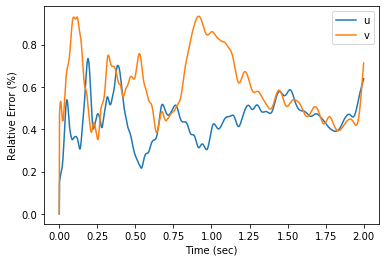

average relative error of u: 0.45467869263487853%
average relative error of v: 0.6416275902335863%

maximum relative error of u: 0.7340606841482201%
maximum relative error of v: 0.9339927943691113%
------------------------------------------------------------------------


In [19]:
# choose # of DEIM basis and DEIM samples
DEIM_basis=int(test_results[np.argsort(test_results[:,-1])[0]][0])
DEIM_samples=int(test_results[np.argsort(test_results[:,-1])[0]][1])
print('# of residual basis: {}'.format(DEIM_basis))
print('# of residual sampes: {}'.format(DEIM_samples))

phi_u=U_u[:,:DEIM_basis]
phi_v=U_v[:,:DEIM_basis]

# Find DEIM smaple points and precompute
z_u=DEIM(phi_u,DEIM_samples)
z_v=DEIM(phi_v,DEIM_samples)

Pu=phi_u.dot(np.linalg.pinv(phi_u[z_u]))
Pv=phi_v.dot(np.linalg.pinv(phi_v[z_v]))

PuTPu=Pu.T.dot(Pu)
PvTPv=Pv.T.dot(Pv)

# neigbor sample points
z_uA=np.unique(np.nonzero(Au2_cur[z_u])[1])
z_uM=np.unique(np.nonzero(M[z_u])[1])
z_uN=np.unique(np.nonzero(N[z_u])[1])

z_vA=np.unique(np.nonzero(Av3_cur[z_v])[1])
z_vM=np.unique(np.nonzero(M[z_v])[1])
z_vN=np.unique(np.nonzero(N[z_v])[1])

z_union=np.union1d(z_uA,z_vA)

z_uA_ind=z_union.searchsorted(z_uA)
z_uM_ind=z_union.searchsorted(z_uM)
z_uN_ind=z_union.searchsorted(z_uN)
z_u_ind=z_union.searchsorted(z_u)

z_vA_ind=z_union.searchsorted(z_vA)
z_vM_ind=z_union.searchsorted(z_vM)
z_vN_ind=z_union.searchsorted(z_vN)
z_v_ind=z_union.searchsorted(z_v)

# subnet for u
m,M2=de_wu2.shape

class Decoder_U_FC(nn.Module):

    def __init__(self,):
        super(Decoder_U_FC, self).__init__()
        self.fc1 = nn.Linear(latent_dim,M2)
        self.fc1.weight = nn.Parameter(torch.ones(de_wu1.shape))
        self.fc1.bias = nn.Parameter(torch.ones(de_bu1.shape))
#         self.fc1.weight = nn.Parameter(torch.tensor(de_wu1))
#         self.fc1.bias = nn.Parameter(torch.tensor(de_bu1))

        self.fc2 = nn.Linear(M2,m,bias=False)
        self.fc2.weight = nn.Parameter(torch.ones(de_wu2.shape))
#         self.fc2.weight = nn.Parameter(torch.tensor(de_wu2))

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x

model = Decoder_U_FC()

x_in=torch.ones(latent_dim)
y_out=model(x_in)

p_hr=z_union

upstream=torch.zeros_like(y_out)
upstream[p_hr]=1.0

y_out.backward(upstream)

# masks for subnet
wu1_mask=model.fc1.weight.grad
wu2_mask=model.fc2.weight.grad

bu1_mask=model.fc1.bias.grad

# subnet sparse weight
idx1=wu1_mask.to_sparse()._indices()
i1=idx1.numpy()[0]
j1=idx1.numpy()[1]
v1=de_wu1[i1,j1]
wu1_sb_sp=sp.csr_matrix(sp.csr_matrix((v1,(i1,j1)),shape=wu1_mask.shape).toarray())

idx2=wu2_mask.to_sparse()._indices()
i2=idx2.numpy()[0]
j2=idx2.numpy()[1]
v2=de_wu2[i2,j2]
wu2_sb_sp=sp.csr_matrix(sp.csr_matrix((v2,(i2,j2)),shape=wu2_mask.shape).toarray())

# subnet compressed weight
i1,j1,v1=sp.find(wu1_sb_sp)
i1_unique,i1_inverse=np.unique(i1,return_inverse=True)
i1_comp=np.arange(i1_unique.size)
i1_comp=i1_comp[i1_inverse]
j1_unique,j1_inverse=np.unique(j1,return_inverse=True)
j1_comp=np.arange(j1_unique.size)
j1_comp=j1_comp[j1_inverse]
wu1_sb_comp_sp=sp.csr_matrix((v1,(i1_comp,j1_comp)),shape=(i1_unique.size,j1_unique.size))

i2,j2,v2=sp.find(wu2_sb_sp)
i2_unique,i2_inverse=np.unique(i2,return_inverse=True)
i2_comp=np.arange(i2_unique.size)
i2_comp=i2_comp[i2_inverse]
j2_unique,j2_inverse=np.unique(j2,return_inverse=True)
j2_comp=np.arange(j2_unique.size)
j2_comp=j2_comp[j2_inverse]
wu2_sb_comp_sp=sp.csr_matrix((v2,(i2_comp,j2_comp)),shape=(i2_unique.size,j2_unique.size))

wu1_sb_comp_dense=wu1_sb_comp_sp.toarray()
wu1_sb_comp_dense=wu1_sb_comp_dense[j2_unique]
wu2_sb_comp_dense=wu2_sb_comp_sp.toarray()

wu1_sb_comp_denseT=wu1_sb_comp_dense.T
wu2_sb_comp_denseT=wu2_sb_comp_dense.T

# subnet compressed bias
bu1_sb_comp_dense=de_bu1[i1_unique]
bu1_sb_comp_dense=bu1_sb_comp_dense[j2_unique]

# Using sparse matrix
wu2_sb_comp_sp=sp.csr_matrix(wu2_sb_comp_dense,dtype='float32')
wu2_sb_comp_spT=sp.csr_matrix(wu2_sb_comp_denseT,dtype='float32')

def decoder_u_sb_np_forward(x):
    z1 = wu1_sb_comp_dense.dot(x) + bu1_sb_comp_dense
    a1 = sigmoid_np(z1)
    y = wu2_sb_comp_dense.dot(a1)  
    return y

def decoder_u_sb_np_forward_backwardT(x):
    z1 = wu1_sb_comp_dense.dot(x) + bu1_sb_comp_dense
    a1 = sigmoid_np(z1)
    y = wu2_sb_comp_dense.dot(a1) 

    dout = wu1_sb_comp_denseT
    dout = (a1*(1-a1))*dout
    dydxT = dout.dot(wu2_sb_comp_denseT)
    return y,dydxT

def decoder_u_sb_sp_forward(x):
    z1 = wu1_sb_comp_dense.dot(x) + bu1_sb_comp_dense
    a1 = sigmoid_np(z1)
    y = sp.csr_matrix.dot(wu2_sb_comp_sp,a1)
    return y

def decoder_u_sb_sp_forward_backwardT(x):
    z1 = wu1_sb_comp_dense.dot(x) + bu1_sb_comp_dense
    a1 = sigmoid_np(z1)
    y = sp.csr_matrix.dot(wu2_sb_comp_sp,a1)

    dout = wu1_sb_comp_denseT
    dout = (a1*(1-a1))*dout
    dydxT = sp.csr_matrix.dot(dout,wu2_sb_comp_spT)
    return y,dydxT

# subnet for v
m,M2=de_wv2.shape

class Decoder_V_FC(nn.Module):

    def __init__(self,):
        super(Decoder_V_FC, self).__init__()
        self.fc1 = nn.Linear(latent_dim,M2)
        self.fc1.weight = nn.Parameter(torch.ones(de_wv1.shape))
        self.fc1.bias = nn.Parameter(torch.ones(de_bv1.shape))
#         self.fc1.weight = nn.Parameter(torch.tensor(de_wv1))
#         self.fc1.bias = nn.Parameter(torch.tensor(de_bv1))

        self.fc2 = nn.Linear(M2,m,bias=False)
        self.fc2.weight = nn.Parameter(torch.ones(de_wv2.shape))
#         self.fc2.weight = nn.Parameter(torch.tensor(de_wv2))

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x

model = Decoder_V_FC()

x_in=torch.ones(latent_dim)
y_out=model(x_in)

p_hr=z_union

upstream=torch.zeros_like(y_out)
upstream[p_hr]=1.0

y_out.backward(upstream)

# masks for subnet
wv1_mask=model.fc1.weight.grad
wv2_mask=model.fc2.weight.grad

bv1_mask=model.fc1.bias.grad

# subnet sparse weight
idx1=wv1_mask.to_sparse()._indices()
i1=idx1.numpy()[0]
j1=idx1.numpy()[1]
v1=de_wv1[i1,j1]
wv1_sb_sp=sp.csr_matrix(sp.csr_matrix((v1,(i1,j1)),shape=wv1_mask.shape).toarray())

idx2=wv2_mask.to_sparse()._indices()
i2=idx2.numpy()[0]
j2=idx2.numpy()[1]
v2=de_wv2[i2,j2]
wv2_sb_sp=sp.csr_matrix(sp.csr_matrix((v2,(i2,j2)),shape=wv2_mask.shape).toarray())

# subnet compressed weight
i1,j1,v1=sp.find(wv1_sb_sp)
i1_unique,i1_inverse=np.unique(i1,return_inverse=True)
i1_comp=np.arange(i1_unique.size)
i1_comp=i1_comp[i1_inverse]
j1_unique,j1_inverse=np.unique(j1,return_inverse=True)
j1_comp=np.arange(j1_unique.size)
j1_comp=j1_comp[j1_inverse]
wv1_sb_comp_sp=sp.csr_matrix((v1,(i1_comp,j1_comp)),shape=(i1_unique.size,j1_unique.size))

i2,j2,v2=sp.find(wv2_sb_sp)
i2_unique,i2_inverse=np.unique(i2,return_inverse=True)
i2_comp=np.arange(i2_unique.size)
i2_comp=i2_comp[i2_inverse]
j2_unique,j2_inverse=np.unique(j2,return_inverse=True)
j2_comp=np.arange(j2_unique.size)
j2_comp=j2_comp[j2_inverse]
wv2_sb_comp_sp=sp.csr_matrix((v2,(i2_comp,j2_comp)),shape=(i2_unique.size,j2_unique.size))

wv1_sb_comp_dense=wv1_sb_comp_sp.toarray()
wv1_sb_comp_dense=wv1_sb_comp_dense[j2_unique]
wv2_sb_comp_dense=wv2_sb_comp_sp.toarray()

wv1_sb_comp_denseT=wv1_sb_comp_dense.T
wv2_sb_comp_denseT=wv2_sb_comp_dense.T

# subnet compressed bias
bv1_sb_comp_dense=de_bv1[i1_unique]
bv1_sb_comp_dense=bv1_sb_comp_dense[j2_unique]

# Using sparse matrix
wv2_sb_comp_sp=sp.csr_matrix(wv2_sb_comp_dense,dtype='float32')
wv2_sb_comp_spT=sp.csr_matrix(wv2_sb_comp_denseT,dtype='float32')

def decoder_v_sb_np_forward(x):
    z1 = wv1_sb_comp_dense.dot(x) + bv1_sb_comp_dense
    a1 = sigmoid_np(z1)
    y = wv2_sb_comp_dense.dot(a1)  
    return y

def decoder_v_sb_np_forward_backwardT(x):
    z1 = wv1_sb_comp_dense.dot(x) + bv1_sb_comp_dense
    a1 = sigmoid_np(z1)
    y = wv2_sb_comp_dense.dot(a1) 

    dout = wv1_sb_comp_denseT
    dout = (a1*(1-a1))*dout
    dydxT = dout.dot(wv2_sb_comp_denseT)
    return y,dydxT

def decoder_v_sb_sp_forward(x):
    z1 = wv1_sb_comp_dense.dot(x) + bv1_sb_comp_dense
    a1 = sigmoid_np(z1)
    y = sp.csr_matrix.dot(wv2_sb_comp_sp,a1)
    return y

def decoder_v_sb_sp_forward_backwardT(x):
    z1 = wv1_sb_comp_dense.dot(x) + bv1_sb_comp_dense
    a1 = sigmoid_np(z1)
    y = sp.csr_matrix.dot(wv2_sb_comp_sp,a1)

    dout = wv1_sb_comp_denseT
    dout = (a1*(1-a1))*dout
    dydxT = sp.csr_matrix.dot(dout,wv2_sb_comp_spT)
    return y,dydxT

# precompute
ZuTau1_cur=au1_cur[z_u]
ZuTAu2_cur=Au2_cur[z_u][:,z_uA]
ZuTau3_cur=au3_cur[z_u]

ZvTav1_cur=av1_cur[z_v]
ZvTav2_cur=av2_cur[z_v]
ZvTAv3_cur=Av3_cur[z_v][:,z_vA]

Au2T_curZu=Au2T_cur[z_uA][:,z_u]
Av3T_curZv=Av3T_cur[z_vA][:,z_v]

ZuTM=M[z_u][:,z_uM]
ZuTN=N[z_u][:,z_uN]
ZvTM=M[z_v][:,z_vM]
ZvTN=N[z_v][:,z_vN]

MTZu=MT[z_uM][:,z_u]
NTZu=NT[z_uN][:,z_u]
MTZv=MT[z_vM][:,z_v]
NTZv=NT[z_vN][:,z_v]

# define functions
def ZuTtheta_u(g_u_sb,g_v_sb,ZuTMg_u,ZuTNg_u):
    return -1/dx*g_u_sb[z_u_ind]*ZuTMg_u-1/dy*g_v_sb[z_u_ind]*ZuTNg_u

def ZvTtheta_v(g_u_sb,g_v_sb,ZvTMg_v,ZvTNg_v):
    return -1/dx*g_u_sb[z_v_ind]*ZvTMg_v-1/dy*g_v_sb[z_v_ind]*ZvTNg_v

def dtheta_udu_hatTZu(g_u_sb,g_v_sb,ZuTMg_u,Jg_u_sbT,Jg_uTMTZu,Jg_uTNTZu):
    return -1/dx*(ZuTMg_u*Jg_u_sbT[:,z_u_ind]+g_u_sb[z_u_ind]*Jg_uTMTZu)-1/dy*g_v_sb[z_u_ind]*Jg_uTNTZu

def dtheta_udv_hatTZu(ZuTNg_u,Jg_v_sbT):
    return -1/dy*ZuTNg_u*Jg_v_sbT[:,z_u_ind]

def dtheta_vdu_hatTZv(ZvTMg_v,Jg_u_sbT):
    return -1/dx*ZvTMg_v*Jg_u_sbT[:,z_v_ind]

def dtheta_vdv_hatTZv(g_u_sb,g_v_sb,ZvTNg_v,Jg_v_sbT,Jg_vTMTZv,Jg_vTNTZv):
    return -1/dx*g_u_sb[z_v_ind]*Jg_vTMTZv-1/dy*(ZvTNg_v*Jg_v_sbT[:,z_v_ind]+g_v_sb[z_v_ind]*Jg_vTNTZv)

def ZuTr_u(g_u_sb,g_v_sb,g_u_sb_prev,ZuTMg_u,ZuTNg_u):
    return g_u_sb[z_u_ind]-g_u_sb_prev[z_u_ind]-dt*(ZuTau1_cur+ZuTAu2_cur.dot(g_u_sb[z_uA_ind])+ZuTau3_cur*g_v_sb[z_u_ind]\
                                                    +ZuTtheta_u(g_u_sb,g_v_sb,ZuTMg_u,ZuTNg_u))

def ZvTr_v(g_u_sb,g_v_sb,g_v_sb_prev,ZvTMg_v,ZvTNg_v):
    return g_v_sb[z_v_ind]-g_v_sb_prev[z_v_ind]-dt*(ZvTav1_cur+ZvTav2_cur*g_u_sb[z_v_ind]+ZvTAv3_cur.dot(g_v_sb[z_vA_ind])\
                                                    +ZvTtheta_v(g_u_sb,g_v_sb,ZvTMg_v,ZvTNg_v))

def dr_udu_hatTZu(g_u_sb,g_v_sb,ZuTMg_u,Jg_u_sbT,Jg_uTMTZu,Jg_uTNTZu):
    return Jg_u_sbT[:,z_u_ind]-dt*(sp.csr_matrix.dot(Jg_u_sbT[:,z_uA_ind],Au2T_curZu)\
                                   +dtheta_udu_hatTZu(g_u_sb,g_v_sb,ZuTMg_u,Jg_u_sbT,Jg_uTMTZu,Jg_uTNTZu))

def dr_udv_hatTZu(ZuTNg_u,Jg_v_sbT):
    return -dt*(ZuTau3_cur*Jg_v_sbT[:,z_u_ind]+dtheta_udv_hatTZu(ZuTNg_u,Jg_v_sbT))

def dr_vdu_hatTZv(ZvTMg_v,Jg_u_sbT):
    return -dt*(ZvTav2_cur*Jg_u_sbT[:,z_v_ind]+dtheta_vdu_hatTZv(ZvTMg_v,Jg_u_sbT))

def dr_vdv_hatTZv(g_u_sb,g_v_sb,ZvTNg_v,Jg_v_sbT,Jg_vTMTZv,Jg_vTNTZv):
    return Jg_v_sbT[:,z_v_ind]-dt*(sp.csr_matrix.dot(Jg_v_sbT[:,z_vA_ind],Av3T_curZv)\
                                   +dtheta_vdv_hatTZv(g_u_sb,g_v_sb,ZvTNg_v,Jg_v_sbT,Jg_vTMTZv,Jg_vTNTZv))

def r_hat(ZuTr_u_cur,ZvTr_v_cur,dr_udu_hatTZu_cur,dr_udv_hatTZu_cur,dr_vdu_hatTZv_cur,dr_vdv_hatTZv_cur):
    r_u_hat=dr_udu_hatTZu_cur.dot(PuTPu.dot(ZuTr_u_cur))+dr_vdu_hatTZv_cur.dot(PvTPv.dot(ZvTr_v_cur))
    r_v_hat=dr_udv_hatTZu_cur.dot(PuTPu.dot(ZuTr_u_cur))+dr_vdv_hatTZv_cur.dot(PvTPv.dot(ZvTr_v_cur))
    return np.concatenate((r_u_hat,r_v_hat))

def J_hat(ZuTr_u_cur,ZvTr_v_cur,dr_udu_hatTZu_cur,dr_udv_hatTZu_cur,dr_vdu_hatTZv_cur,dr_vdv_hatTZv_cur):
    J11_hat=dr_udu_hatTZu_cur.dot(PuTPu.dot(dr_udu_hatTZu_cur.T))+dr_vdu_hatTZv_cur.dot(PvTPv.dot(dr_vdu_hatTZv_cur.T))
    J12_hat=dr_udu_hatTZu_cur.dot(PuTPu.dot(dr_udv_hatTZu_cur.T))+dr_vdu_hatTZv_cur.dot(PvTPv.dot(dr_vdv_hatTZv_cur.T))
    J21_hat=dr_udv_hatTZu_cur.dot(PuTPu.dot(dr_udu_hatTZu_cur.T))+dr_vdv_hatTZv_cur.dot(PvTPv.dot(dr_vdu_hatTZv_cur.T))
    J22_hat=dr_udv_hatTZu_cur.dot(PuTPu.dot(dr_udv_hatTZu_cur.T))+dr_vdv_hatTZv_cur.dot(PvTPv.dot(dr_vdv_hatTZv_cur.T))
    return np.block([[J11_hat,J12_hat],[J21_hat,J22_hat]])

# run NM-ROM
t_start_pg_DEIM=time.time()

# solution
u_reduced=np.zeros((nt+1,latent_dim))
v_reduced=np.zeros((nt+1,latent_dim))
u_rom_pg_DEIM=np.zeros((nt+1,ny*nx))
v_rom_pg_DEIM=np.zeros((nt+1,ny*nx))

# IC
u_reduced[0]=np.copy(u_hat0)
v_reduced[0]=np.copy(v_hat0)
u_rom_pg_DEIM[0]=np.copy(u0)
v_rom_pg_DEIM[0]=np.copy(v0)

for k in range(nt):
#             print("")
#             print(k,"th time step:")

    u_hat_prev=np.copy(u_reduced[k])
    v_hat_prev=np.copy(v_reduced[k])

    g_u_sb_prev=u_rom_pg_DEIM[k,free_raveled_indicies[z_union]]-u_ref[z_union]
    g_v_sb_prev=v_rom_pg_DEIM[k,free_raveled_indicies[z_union]]-v_ref[z_union]

    u_hat=np.copy(u_reduced[k])
    v_hat=np.copy(v_reduced[k])

    g_u_sb,Jg_u_sbT=decoder_u_sb_np_forward_backwardT(u_hat)
    g_v_sb,Jg_v_sbT=decoder_v_sb_np_forward_backwardT(v_hat)

    ZuTMg_u=ZuTM.dot(g_u_sb[z_uM_ind])
    ZuTNg_u=ZuTN.dot(g_u_sb[z_uN_ind])
    ZvTMg_v=ZvTM.dot(g_v_sb[z_vM_ind])
    ZvTNg_v=ZvTN.dot(g_v_sb[z_vN_ind])

    Jg_uTMTZu=sp.csc_matrix.dot(Jg_u_sbT[:,z_uM_ind],MTZu)
    Jg_uTNTZu=sp.csc_matrix.dot(Jg_u_sbT[:,z_uN_ind],NTZu)
    Jg_vTMTZv=sp.csc_matrix.dot(Jg_v_sbT[:,z_vM_ind],MTZv)
    Jg_vTNTZv=sp.csc_matrix.dot(Jg_v_sbT[:,z_vN_ind],NTZv)

    ZuTr_u_cur=ZuTr_u(g_u_sb,g_v_sb,g_u_sb_prev,ZuTMg_u,ZuTNg_u)
    ZvTr_v_cur=ZvTr_v(g_u_sb,g_v_sb,g_v_sb_prev,ZvTMg_v,ZvTNg_v)

    dr_udu_hatTZu_cur=dr_udu_hatTZu(g_u_sb,g_v_sb,ZuTMg_u,Jg_u_sbT,Jg_uTMTZu,Jg_uTNTZu)
    dr_udv_hatTZu_cur=dr_udv_hatTZu(ZuTNg_u,Jg_v_sbT)
    dr_vdu_hatTZv_cur=dr_vdu_hatTZv(ZvTMg_v,Jg_u_sbT)
    dr_vdv_hatTZv_cur=dr_vdv_hatTZv(g_u_sb,g_v_sb,ZvTNg_v,Jg_v_sbT,Jg_vTMTZv,Jg_vTNTZv)

    residual_hat=r_hat(ZuTr_u_cur,ZvTr_v_cur,dr_udu_hatTZu_cur,dr_udv_hatTZu_cur,dr_vdu_hatTZv_cur,dr_vdv_hatTZv_cur)

    for itr in range(maxitr):
        Jacobian_hat=J_hat(ZuTr_u_cur,ZvTr_v_cur,dr_udu_hatTZu_cur,dr_udv_hatTZu_cur,dr_vdu_hatTZv_cur,dr_vdv_hatTZv_cur)

        delta_reduced=np.linalg.solve(Jacobian_hat,-residual_hat)

        u_hat+=delta_reduced[:latent_dim]
        v_hat+=delta_reduced[latent_dim:]

        g_u_sb,Jg_u_sbT=decoder_u_sb_np_forward_backwardT(u_hat)
        g_v_sb,Jg_v_sbT=decoder_v_sb_np_forward_backwardT(v_hat)

        ZuTMg_u=ZuTM.dot(g_u_sb[z_uM_ind])
        ZuTNg_u=ZuTN.dot(g_u_sb[z_uN_ind])
        ZvTMg_v=ZvTM.dot(g_v_sb[z_vM_ind])
        ZvTNg_v=ZvTN.dot(g_v_sb[z_vN_ind])

        Jg_uTMTZu=sp.csc_matrix.dot(Jg_u_sbT[:,z_uM_ind],MTZu)
        Jg_uTNTZu=sp.csc_matrix.dot(Jg_u_sbT[:,z_uN_ind],NTZu)
        Jg_vTMTZv=sp.csc_matrix.dot(Jg_v_sbT[:,z_vM_ind],MTZv)
        Jg_vTNTZv=sp.csc_matrix.dot(Jg_v_sbT[:,z_vN_ind],NTZv)

        ZuTr_u_cur=ZuTr_u(g_u_sb,g_v_sb,g_u_sb_prev,ZuTMg_u,ZuTNg_u)
        ZvTr_v_cur=ZvTr_v(g_u_sb,g_v_sb,g_v_sb_prev,ZvTMg_v,ZvTNg_v)

        dr_udu_hatTZu_cur=dr_udu_hatTZu(g_u_sb,g_v_sb,ZuTMg_u,Jg_u_sbT,Jg_uTMTZu,Jg_uTNTZu)
        dr_udv_hatTZu_cur=dr_udv_hatTZu(ZuTNg_u,Jg_v_sbT)
        dr_vdu_hatTZv_cur=dr_vdu_hatTZv(ZvTMg_v,Jg_u_sbT)
        dr_vdv_hatTZv_cur=dr_vdv_hatTZv(g_u_sb,g_v_sb,ZvTNg_v,Jg_v_sbT,Jg_vTMTZv,Jg_vTNTZv)

        residual_hat=r_hat(ZuTr_u_cur,ZvTr_v_cur,dr_udu_hatTZu_cur,dr_udv_hatTZu_cur,dr_vdu_hatTZv_cur,dr_vdv_hatTZv_cur)

        R=np.linalg.norm(residual_hat)
#                 print(itr,"th Newton iteration", "R:", "{:.8e}".format(R))

        if R<tol:
            u_reduced[k+1]=u_hat.copy()
            v_reduced[k+1]=v_hat.copy()
            u_rom_pg_DEIM[k+1,free_raveled_indicies]=u_ref+decoder_u_sp_forward(u_hat)
            v_rom_pg_DEIM[k+1,free_raveled_indicies]=v_ref+decoder_v_sp_forward(v_hat)
            # BC from exact solution
            u_rom_pg_DEIM[k+1,fixed_raveled_indicies]=u0[fixed_raveled_indicies].copy()
            v_rom_pg_DEIM[k+1,fixed_raveled_indicies]=v0[fixed_raveled_indicies].copy()
            break

    if R>=tol:
        print("\n non converged after {}th iteration".format(maxitr))
        break  

#     u_reduced[k+1]=u_hat.copy()
#     v_reduced[k+1]=v_hat.copy()
#     u_rom_pg_DEIM[k+1,free_raveled_indicies]=u_ref+decoder_u_sp_forward(u_hat)
#     v_rom_pg_DEIM[k+1,free_raveled_indicies]=v_ref+decoder_v_sp_forward(v_hat)
#     # BC from exact solution
#     u_rom_pg_DEIM[k+1,fixed_raveled_indicies]=u0[fixed_raveled_indicies].copy()
#     v_rom_pg_DEIM[k+1,fixed_raveled_indicies]=v0[fixed_raveled_indicies].copy()

t_elapsed_pg_DEIM=time.time()-t_start_pg_DEIM
print()
print('Time elapsed: {} sec'.format(t_elapsed_pg_DEIM))

# compute errors
u_rel_err=np.linalg.norm(u_full-u_rom_pg_DEIM,ord=2,axis=1)/np.linalg.norm(u_full,ord=2,axis=1)*100
v_rel_err=np.linalg.norm(v_full-v_rom_pg_DEIM,ord=2,axis=1)/np.linalg.norm(v_full,ord=2,axis=1)*100
plt.plot(dt*np.arange(nt+1),u_rel_err,dt*np.arange(nt+1),v_rel_err)
plt.xlabel('Time (sec)')
plt.ylabel('Relative Error (%)')
plt.legend(('u','v'))
plt.show()

u_avg_rel_err=np.sqrt(np.sum(np.linalg.norm(u_full-u_rom_pg_DEIM,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(u_full,ord=2,axis=1)**2))*100
v_avg_rel_err=np.sqrt(np.sum(np.linalg.norm(v_full-v_rom_pg_DEIM,ord=2,axis=1)**2))/np.sqrt(np.sum(np.linalg.norm(v_full,ord=2,axis=1)**2))*100

print("average relative error of u: {}%".format(u_avg_rel_err))
print("average relative error of v: {}%".format(v_avg_rel_err))
print()
print("maximum relative error of u: {}%".format(np.max(u_rel_err)))
print("maximum relative error of v: {}%".format(np.max(v_rel_err)))
print('-'*72)         